# Predicting Housing Market using on ai

### by: Ahad Beykaei

Predicting housing price in the Toronto area using recurrent neural network (RNN) based on different house features and also based on the previous selling/buying transactions.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Toronto_housing_data_86_95_v2.csv', dtype={"Style": 'unicode', "ROOMS": 'unicode', 'BEDS': 'unicode'})
df.head()

Year  Month NEWOLD  DAYSON  SOLDDATE         LST96        SLD96  LSTPRC  \
0    87      1      R      54  1/5/1987  192311.46220  186191.8693  147700   
1    87      1      R      26  1/5/1987  383971.90390  369779.6565  294900   
2    87      1      R      23  1/5/1987   98824.91524   97653.0783   75900   
3    87      1      N      26  1/5/1987  152989.82270  145828.5969  117500   
4    87      1      R      42  1/5/1987  156114.72120  151036.7611  119900   

   SLDPRC Municipal   ...    Type2 Style EXTER_1 Garage ROOMS BEDS BEDS_2  \
0  143000    R HILL   ...        D     1       B            5    3      3   
1  284000    R HILL   ...        D     2       B            0    4      4   
2   75000   TORONTO   ...        D     2       O            4    2      2   
3  112000   TORONTO   ...        D     1       A            5    2      2   
4  116000   TORONTO   ...        S     2       O            6    3      3   

   BEDS_3     LONG      LAT  
0       3 -79.4229  43.8929  
1       4 -79.4648  43.9531  
2       1 -79.3376  43.6673  
3       1 -79.3210  43.6694  
4       3 -79.3213  43.6709  

[5 rows x 21 columns]

In [3]:
print(df.columns)
print(df.shape)

Index(['Year', 'Month', 'NEWOLD', 'DAYSON', 'SOLDDATE', 'LST96', 'SLD96',
       'LSTPRC', 'SLDPRC', 'Municipal', 'Type', 'Type2', 'Style', 'EXTER_1',
       'Garage', 'ROOMS', 'BEDS', 'BEDS_2', 'BEDS_3', 'LONG', 'LAT'],
      dtype='object')
(262669, 21)


In [4]:
df = df[['Year', 'Month', 'NEWOLD', 'SOLDDATE', 'LST96', 'SLD96',
       'LSTPRC', 'SLDPRC', 'Municipal', 'Type2', 'Style',
       'BEDS', 'LONG', 'LAT']]

In [5]:
print(df.groupby('Type2').Type2.count())
print(df.groupby('Style').Style.count())
print(df.groupby('NEWOLD').NEWOLD.count())

Type2
A         10125
D        194434
Other       495
S         57615
Name: Type2, dtype: int64
Style
        140
0     10669
1     62244
2    145427
3     13066
4     13636
5      6725
6      1585
7      9162
8        13
9         2
Name: Style, dtype: int64
NEWOLD
         74
F      1742
N    114560
R    138997
T       663
X      6633
Name: NEWOLD, dtype: int64


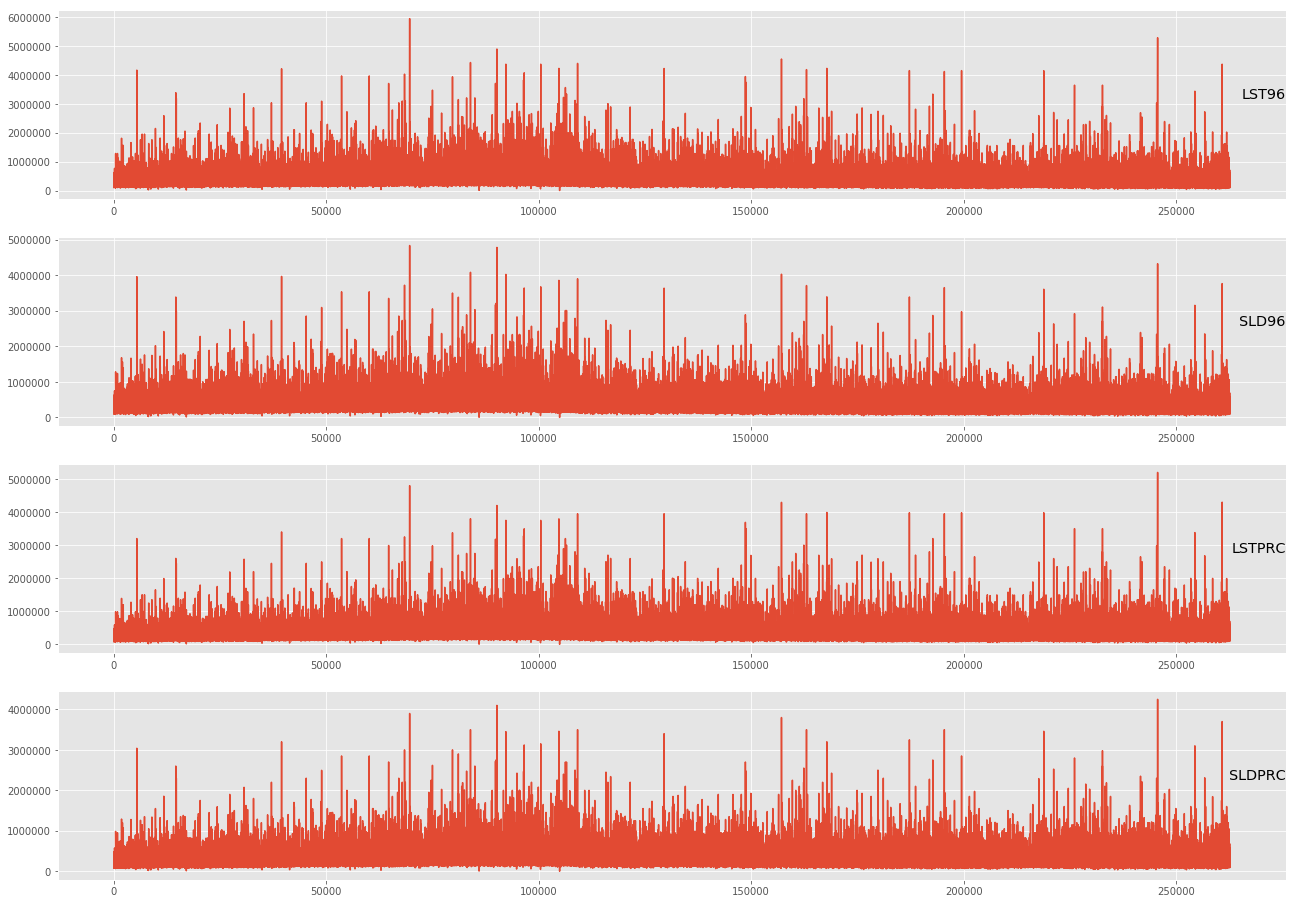

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# load dataset
values = df.values
# specify columns to plot
groups = [4, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(22,16))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [7]:
X_cat = df[['NEWOLD', 'Municipal', 'Type2', 'Style', 'BEDS', ]]
# integer encode direction
encoder = LabelEncoder()
X_cat = X_cat.apply(encoder.fit_transform)
# 1. INSTANTIATE
enc = OneHotEncoder()
# 2. FIT
enc.fit(X_cat)
# 3. Transform
X_cat = enc.transform(X_cat).toarray()
X_cat.shape

(262669, 63)

In [8]:
X_cat

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [29]:
df[['LST96', 'SLD96', 'LSTPRC', 'SLDPRC', 'LONG', 'LAT']].describe()

LST96         SLD96        LSTPRC        SLDPRC           LONG  \
count  2.626690e+05  2.626690e+05  2.626690e+05  2.626690e+05  262669.000000   
mean   2.943775e+05  2.787223e+05  2.616583e+05  2.475710e+05     -79.415238   
std    1.714709e+05  1.568609e+05  1.517155e+05  1.379743e+05       0.197361   
min    1.392305e+03  1.392305e+03  1.250000e+03  1.250000e+03     -80.117700   
25%    2.030155e+05  1.931953e+05  1.799000e+05  1.740000e+05     -79.547700   
50%    2.539886e+05  2.410078e+05  2.250000e+05  2.150000e+05     -79.420300   
75%    3.274017e+05  3.112804e+05  2.890000e+05  2.750000e+05     -79.300400   
max    5.948373e+06  4.833053e+06  5.200000e+06  4.250000e+06     -78.442500   

                 LAT  
count  262669.000000  
mean       43.730060  
std         0.112917  
min        43.298500  
25%        43.666300  
50%        43.718000  
75%        43.802800  
max        44.507000

In [10]:
# X_scale = df[['LST96', 'SLD96', 'LSTPRC', 'SLDPRC', 'LONG', 'LAT']]
# X_scale1 = X_scale[['LST96', 'SLD96', 'LSTPRC', 'SLDPRC']].values
X_scale1 = df[['SLD96']].values
X_scale2 = df[['LONG', 'LAT']].values
# ensure all data is float
X_scale1 = X_scale1.astype('float32')
X_scale2 = X_scale2.astype('float32')
# normalize features
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(-1, 1))
X_scale1 = scaler1.fit_transform(X_scale1)
X_scale2 = scaler2.fit_transform(X_scale2)

In [40]:
X_year = df[['Type2', 'Year', 'Month', 'SOLDDATE']].values

In [11]:
# Concatinating the encoded categorical features with the numerical features
X = np.concatenate((X_cat, X_scale2, X_scale1), axis=1)
print(X.shape)
print(X[70])

(262669, 66)
[ 0.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          1.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.          0.
  0.23722076 -0.07472229  0.03458269]


In [46]:
df[['SLD96']]

SLD96
0       186191.86930
1       369779.65650
2        97653.07830
3       145828.59690
4       151036.76110
5       390612.31320
6       105465.32460
7       197259.21820
8       348295.97930
9       212883.71070
10      179681.66410
11       97002.05778
12      139318.39170
13      384102.10800
14      145828.59690
15      203118.40290
16      135412.26860
17      134110.22750
18      319000.05580
19      305979.64530
20      167963.29470
21      462224.57060
22      377591.90280
23      182285.74620
24      195306.15660
25      282542.90650
26      217440.85430
27      157546.96630
28      169916.35620
29      319000.05580
...              ...
262639  254204.31100
262640  203363.44880
262641  234681.41990
262642  153437.72210
262643  109714.58060
262644  206413.90050
262645  198279.36260
262646  156589.85560
262647  184043.92120
262648  211497.98680
262649  152522.58660
262650  564333.57040
262651  325381.51810
262652  172858.93150
262653  148455.31760
262654   91513.55196
262655  264372.48340
262656  226241.83680
262657  192178.45910
262658  168791.66250
262659  416895.07000
262660  334551.17600
262661  172858.93150
262662   95580.82094
262663  171842.11420
262664  196754.13670
262665  320297.43190
262666  157708.35450
262667  285217.23690
262668  246578.18170

[262669 rows x 1 columns]

In [61]:
SLD96 = df[['SLD96']]
pd.concat([SLD96.shift(5), SLD96], axis=1).head(10)

SLD96        SLD96
0          NaN  186191.8693
1          NaN  369779.6565
2          NaN   97653.0783
3          NaN  145828.5969
4          NaN  151036.7611
5  186191.8693  390612.3132
6  369779.6565  105465.3246
7   97653.0783  197259.2182
8  145828.5969  348295.9793
9  151036.7611  212883.7107

## Convert series to supervised learning

In [91]:
# convert series to supervised learning
def series_to_supervised(data, lag_in=0 , n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i + lag_in))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	cols.append(SLD96)
	agg = pd.concat(cols, axis=1)
	names += ['SOLD96']
	agg.columns = names
#	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [128]:
# frame as supervised learning
lag = 300 # n_lag before lag = 60 sells
n_lag = 10
n_features = X.shape[1] #
reframed = series_to_supervised(X, lag, n_lag, 1)

In [129]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[-1], axis=1, inplace=True)
reframed.shape

(262359, 726)

In [130]:
reframed.head()

var1(t-10)  var2(t-10)  var3(t-10)  var4(t-10)  var5(t-10)  var6(t-10)  \
310         0.0         0.0         0.0         1.0         0.0         0.0   
311         0.0         0.0         0.0         1.0         0.0         0.0   
312         0.0         0.0         0.0         1.0         0.0         0.0   
313         0.0         0.0         1.0         0.0         0.0         0.0   
314         0.0         0.0         0.0         1.0         0.0         0.0   

     var7(t-10)  var8(t-10)  var9(t-10)  var10(t-10)    ...     var57(t)  \
310         0.0         0.0         0.0          0.0    ...          0.0   
311         0.0         0.0         0.0          0.0    ...          1.0   
312         0.0         0.0         0.0          0.0    ...          0.0   
313         0.0         0.0         0.0          0.0    ...          1.0   
314         0.0         0.0         0.0          0.0    ...          1.0   

     var58(t)  var59(t)  var60(t)  var61(t)  var62(t)  var63(t)  var64(t)  \
310       0.0       0.0       0.0       0.0       0.0       0.0 -0.176819   
311       0.0       0.0       0.0       0.0       0.0       0.0  0.004654   
312       0.0       0.0       0.0       0.0       0.0       0.0 -0.185295   
313       0.0       0.0       0.0       0.0       0.0       0.0 -0.352074   
314       0.0       0.0       0.0       0.0       0.0       0.0 -0.185890   

     var65(t)  var66(t)  
310 -0.444107  0.081904  
311 -0.047417  0.041616  
312 -0.431358  0.020192  
313 -0.439636  0.057381  
314 -0.418457  0.027468  

[5 rows x 726 columns]

In [147]:
# split into train and test sets
values = reframed.values
n_train = 150000 # train on first 100,000 rows
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
train_X = np.delete(np.pad(train_X, (0, 1), mode='constant', constant_values=0), train.shape[0], 0)
test_X, test_y = test[:, :-1], test[:, -1]
test_X = np.delete(np.pad(test_X, (0, 1), mode='constant', constant_values=0), test.shape[0], 0)
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag+1, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag+1, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(150000, 726) 150000 (150000,)
(150000, 11, 66) (150000,) (112359, 11, 66) (112359,)


In [144]:
test_X[test.shape[0]-1]

(112359, 11, 66)

In [133]:
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]) ))
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1))

In [134]:
# compile and fit network
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=150, batch_size=500, validation_data=[test_X, test_y], verbose=2, shuffle=False)

Train on 150000 samples, validate on 112359 samples
Epoch 1/150
48s - loss: 0.0168 - val_loss: 0.0122
Epoch 2/150
47s - loss: 0.0133 - val_loss: 0.0126
Epoch 3/150
47s - loss: 0.0130 - val_loss: 0.0127
Epoch 4/150
46s - loss: 0.0128 - val_loss: 0.0120
Epoch 5/150
46s - loss: 0.0128 - val_loss: 0.0117
Epoch 6/150
46s - loss: 0.0127 - val_loss: 0.0115
Epoch 7/150
46s - loss: 0.0127 - val_loss: 0.0114
Epoch 8/150
46s - loss: 0.0127 - val_loss: 0.0115
Epoch 9/150
48s - loss: 0.0126 - val_loss: 0.0116
Epoch 10/150
47s - loss: 0.0126 - val_loss: 0.0115
Epoch 11/150
47s - loss: 0.0125 - val_loss: 0.0114
Epoch 12/150
46s - loss: 0.0124 - val_loss: 0.0114
Epoch 13/150
46s - loss: 0.0125 - val_loss: 0.0113
Epoch 14/150
46s - loss: 0.0124 - val_loss: 0.0110
Epoch 15/150
47s - loss: 0.0123 - val_loss: 0.0109
Epoch 16/150
46s - loss: 0.0123 - val_loss: 0.0109
Epoch 17/150
46s - loss: 0.0122 - val_loss: 0.0109
Epoch 18/150
46s - loss: 0.0122 - val_loss: 0.0109
Epoch 19/150
46s - loss: 0.0121 - val_l

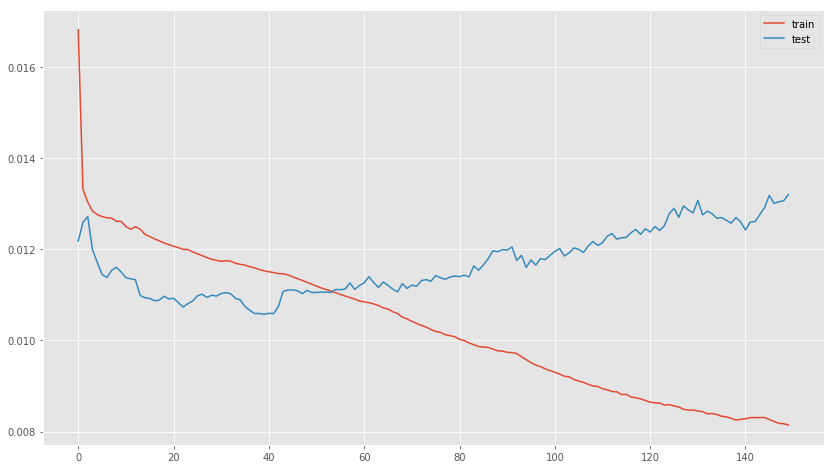

In [135]:
# plot history
pyplot.figure(figsize=(14,8))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [148]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], (n_lag+1)*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler1.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler1.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 121249.553


In [150]:
# make a prediction
yhat = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], (n_lag+1)*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, train_X[:, -7:]), axis=1)
inv_yhat = scaler1.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y = concatenate((train_y, train_X[:, -7:]), axis=1)
inv_y = scaler1.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 111040.857


In [125]:
y_predict = np.append(np.zeros(train_y.shape[0]), yhat)
print(values.shape[0], y_predict.shape[0])

262449 262454


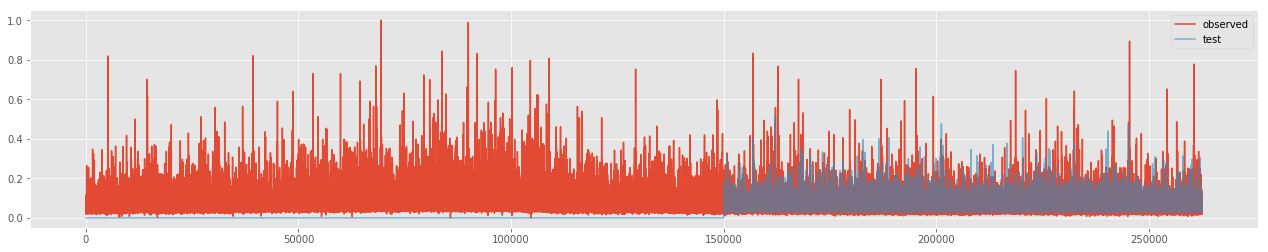

In [126]:
pyplot.figure(figsize=(22,4))
pyplot.plot(values[:, -1], label='observed')
pyplot.plot(y_predict, label='test', alpha=0.6)
pyplot.legend()
pyplot.show()

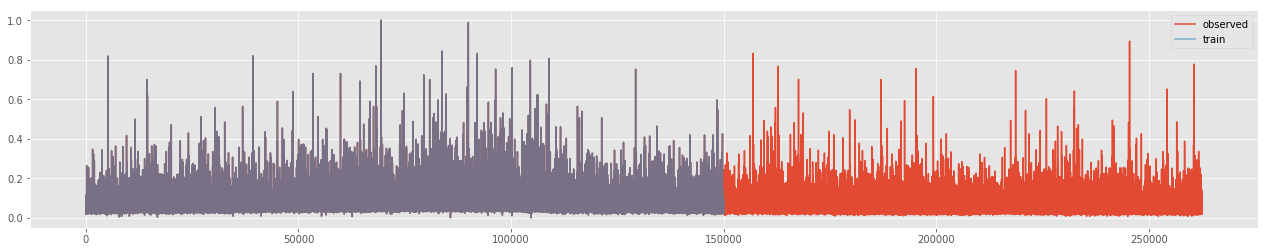

In [127]:
pyplot.figure(figsize=(22,4))
pyplot.plot(values[:, -1], label='observed')
pyplot.plot(train_y, label='train', alpha=0.6)
pyplot.legend()
pyplot.show()